# Notebook to create a lens model that includes dark matter halos

In [1]:
# import standard python libraries
import numpy as np
import scipy
import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy



In [2]:
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

### Recall the simulation for a quadruply lensed quasar

In [3]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0, 0
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = 0, 0

# brightness of the source
source_brightness = 1

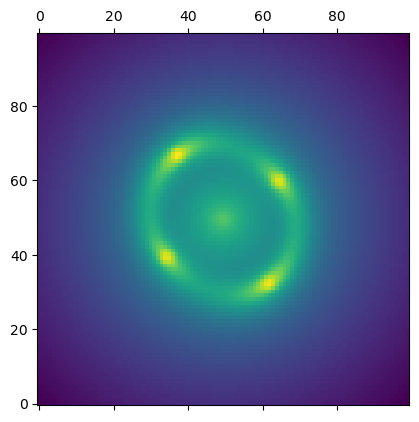

In [4]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

### Q: print out the magnifications of the image

### Q: create the caustics and critical curves plot

## Add a dark matter halo to your simulation
###This is done using the NFW (Navarro-Frenk-White model) 

In [5]:
# NFW profile
nfw_x, nfw_y = 0.6, 0.6

# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0, 0
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = 0, 0

# brightness of the source
source_brightness = 1

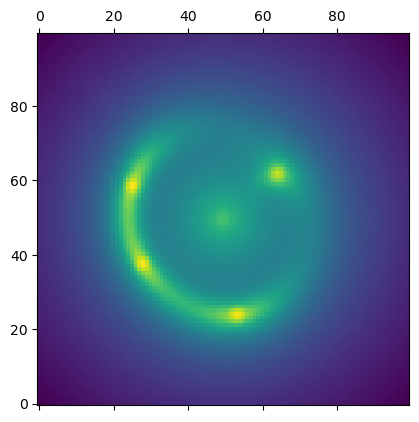

In [6]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

# NFW is the added substructure to the lens model
lens_model_list = ['EPL', 'SHEAR', 'NFW']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}

### NFW parameters
# this is the substructure that is added to the lens model
# what happens if you change these values?
kwargs_nfw = {'alpha_Rs': 0.5, 'Rs': 10, 'center_x': nfw_x, 'center_y':nfw_y}
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_ellipse = {'amp': 4000. * source_brightness, 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

### Q: print out the magnifications of the images, compare to when you don't have any dark matter halo

### Q: create the caustic and critical curve plot

## Visualize the position of the dark matter halo

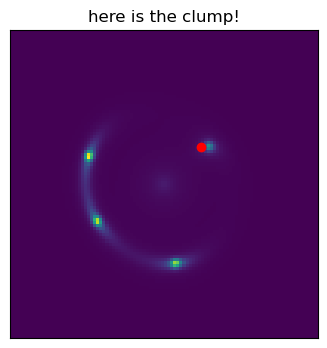

In [7]:
from lenstronomy.Data.coord_transforms import Coordinates
x_grid, y_grid, ra_at_xy_0, dec_at_xy_0, x_at_radec_0, y_at_radec_0, Mpix2coord, Mcoord2pix = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, inverse=False)
coordinates = Coordinates(ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0, transform_pix2angle=Mpix2coord)

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_sim, origin='lower')
ax.set_title("here is the clump!")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


for i in range(2, len(lens_model_list)):
    kwargs = kwargs_lens[i]
    x_pos, y_pos = coordinates.map_coord2pix(kwargs['center_x'], kwargs['center_y'])
    ax.plot(x_pos, y_pos, 'or')
plt.show()

## Add another dark matter halo in a different place
